# Daten zur Raumgliederung
In diesem Notebook werden die Informationen zum durchschnittlichen CO2-Ausstoss der in einer Gemeinde registrierten Personenwagen mit Daten zur Raumgliederung ergänzt. Diese werden vom [Bundesamt für Statistik zur Verfügung gestellt](https://www.bfs.admin.ch/bfs/de/home/statistiken/querschnittsthemen/raeumliche-analysen/raeumliche-gliederungen/raeumliche-typologien.html).

<h1>Inhaltsverzeichnis<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Datenimport" data-toc-modified-id="Datenimport-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Datenimport</a></span><ul class="toc-item"><li><span><a href="#Hauptdatensatz" data-toc-modified-id="Hauptdatensatz-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Hauptdatensatz</a></span></li><li><span><a href="#Raumtypologien" data-toc-modified-id="Raumtypologien-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Raumtypologien</a></span></li><li><span><a href="#Berggebiete" data-toc-modified-id="Berggebiete-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Berggebiete</a></span></li><li><span><a href="#Städte" data-toc-modified-id="Städte-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Städte</a></span></li><li><span><a href="#Wohnbevölkerung" data-toc-modified-id="Wohnbevölkerung-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Wohnbevölkerung</a></span></li></ul></li><li><span><a href="#Auswertungen" data-toc-modified-id="Auswertungen-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Auswertungen</a></span></li><li><span><a href="#Exporte-für-Interaktiv" data-toc-modified-id="Exporte-für-Interaktiv-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exporte für Interaktiv</a></span></li></ul></div>

In [1]:
# Importieren der nötigen Erweiterungen. 
import pandas as pd
from requests import post, get
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import geopandas as gpd

## Datenimport

### Hauptdatensatz

In [2]:
# Die Hauptdaten werden eingelesen.
df = pd.read_csv('daten/co2_daten_gefiltert_gruppiert.csv', index_col='BFS-Gemeinde-Nr')

In [3]:
# Das offizielle Gemeindeverzeichnis wird eingelesen. 
df_gemeinden = pd.read_excel('Gemeindestand_2018.xlsx')
df_gemeinden.set_index('BFS Gde-nummer', inplace=True, drop=True)
df_gemeinden = df_gemeinden[['Gemeindename']]

In [4]:
# Die Gemeindenamen werden im Hauptdatensatz ergänzt. 
df = pd.merge(df_gemeinden, df, left_index=True, right_index=True, how='right')

### Raumtypologien

In [5]:
# Die Daten zu den Raumtypologien des BfS werden importiert. 
url = 'https://www.agvchapp.bfs.admin.ch/de/typologies/results/xls?SnapshotDate=01.01.2018&SelectedTypologies%5B0%5D=HR_GDETYP2012&SelectedTypologies%5B1%5D=HR_MONT2019'
r = post(url)
df_raumtypologien = pd.read_excel(r.content, encoding = 'ISO-8859-1', skiprows=1)
df_raumtypologien = df_raumtypologien.dropna(subset=['BFS Gde-nummer'])
df_raumtypologien['BFS Gde-nummer'] = df_raumtypologien['BFS Gde-nummer'].apply(lambda x: int(x))
df_raumtypologien.set_index('BFS Gde-nummer', inplace=True, drop=True)

In [6]:
# Statt der Variablen werden die Kategoriennamen verwendet. 
temp_dict = {1: 'städtisch', 2: 'intermediär', 3: 'ländlich'}
df_raumtypologien['Stadt/Land-Typologie'] = df_raumtypologien['Stadt/Land-Typologie'].astype('int')
df_raumtypologien['Stadt/Land-Typologie'] = df_raumtypologien['Stadt/Land-Typologie'].map(temp_dict)

temp_dict = {11: 'Städtische Gemeinde einer grossen Agglomeration', 
             12: 'Städtische Gemeinde einer mittelgrossen Agglomeration', 
             13: 'Städtische Gemeinde einer kleinen oder ausserhalb einer Agglomeration', 
             21: 'Periurbane Gemeinde hoher Dichte', 
             22: 'Periurbane Gemeinde mittlerer Dichte',
             23: 'Periurbane Gemeinde geringer Dichte',
             31: 'Ländliche Zentrumsgemeinde',
             32: 'Ländliche zentral gelegene Gemeinde', 
             33: 'Ländliche periphere Gemeinde'}

df_raumtypologien['Gemeindetypologie 2012 (9 Typen)'] = df_raumtypologien['Gemeindetypologie 2012 (9 Typen)'].astype('int')
df_raumtypologien['Gemeindetypologie 2012 (9 Typen)'] = df_raumtypologien['Gemeindetypologie 2012 (9 Typen)'].map(temp_dict)

In [7]:
# Die Raumtypologien und der Hauptdatensatz werden zusammengeführt. 
df = pd.merge(df, df_raumtypologien[['Kanton', 'Bezirks-nummer', 'Bezirksname', 'Stadt/Land-Typologie', 'Gemeindetypologie 2012 (9 Typen)']], 
                             left_index=True, right_index=True, how='right')

### Berggebiete

In [8]:
# Die Daten zu den Bergregionen des BfSwerden importiert. 
url = 'https://www.agvchapp.bfs.admin.ch/de/typologies/results/xls?SnapshotDate=01.01.2018&SelectedTypologies%5B0%5D=HR_MONT2019'
r = post(url)
df_bergregionen = pd.read_excel(r.content, encoding = 'ISO-8859-1', skiprows=1)
df_bergregionen = df_bergregionen.dropna(subset=['BFS Gde-nummer'])
df_bergregionen['BFS Gde-nummer'] = df_bergregionen['BFS Gde-nummer'].apply(lambda x: int(x))
df_bergregionen.set_index('BFS Gde-nummer', inplace=True, drop=True)

In [9]:
# Statt der Variablen werden die Kategoriennamen verwendet. 
temp_dict = {0: 'Gemeinde ausseralb der Berggebiete', 1: 'Gemeinde im Berggebiet'}
df_bergregionen['Berggebiete'] = df_bergregionen['Berggebiete'].astype('int')
df_bergregionen['Berggebiete'] = df_bergregionen['Berggebiete'].map(temp_dict)

In [10]:
# Die Raumtypologien und der Hauptdatensatz werden zusammengeführt. 
df = pd.merge(df, df_bergregionen[['Berggebiete']], left_index=True, right_index=True, how='left')

### Städte

In [11]:
# Die Daten zu den Bergregionen des BfSwerden importiert. 
url = 'https://www.agvchapp.bfs.admin.ch/de/typologies/results/xls?SnapshotDate=01.01.2018&SelectedTypologies%5B0%5D=HR_STADTE2012'
r = post(url)
df_städte = pd.read_excel(r.content, encoding = 'ISO-8859-1', skiprows=1)
df_städte = df_städte.dropna(subset=['BFS Gde-nummer'])
df_städte['BFS Gde-nummer'] = df_städte['BFS Gde-nummer'].apply(lambda x: int(x))
df_städte.set_index('BFS Gde-nummer', inplace=True, drop=True)

In [12]:
# Statt der Variablen werden die Kategoriennamen verwendet. 
temp_dict = {0: 'keine Stadt', 1: 'Stadt'}
df_städte['Statistische Städte 2012'] = df_städte['Statistische Städte 2012'].astype('int')
df_städte['Statistische Städte 2012'] = df_städte['Statistische Städte 2012'].map(temp_dict)

In [13]:
# Die Angaben zu den Städten und der Hauptdatensatz werden zusammengeführt. 
df = pd.merge(df, df_städte[['Statistische Städte 2012']], left_index=True, right_index=True, how='left')

### Wohnbevölkerung

In [14]:
# Daten zu den Bevölkerungszahlen des BfS werden importiert und aufbereitet. 
url = 'https://www.bfs.admin.ch/bfsstatic/dam/assets/7966022/master'
r = get(url)

df_bevölkerung = pd.read_excel(r.content, encoding = 'ISO-8859-1', skiprows=3)
df_bevölkerung = df_bevölkerung.iloc[:,:4]
df_bevölkerung = df_bevölkerung.dropna(subset=['Unnamed: 0'])
df_bevölkerung = df_bevölkerung[df_bevölkerung['Unnamed: 0'].str.startswith('.')]
df_bevölkerung['bfsnr'] = df_bevölkerung['Unnamed: 0'].apply(lambda x: int(x.split(' ')[0].replace('......', '')))
df_bevölkerung.set_index('bfsnr', inplace=True, drop=True)
del df_bevölkerung['Unnamed: 0']
df_bevölkerung.columns = ['bev_' + x.lower() for x in df_bevölkerung.columns]

In [15]:
# Die beiden Datensätze werden zusammengeführt. 
df = pd.merge(df, df_bevölkerung, left_index=True, right_index=True, how='left')

In [16]:
# Der Datensatz wird abgespeichert.
del df['ort']
df.columns = ['gemeinde', 'co2', 'anz_fahrzeuge', 'kanton', 'bezirksnummer', 'bezirksname', 'stadt_land', 'gemeindetyp', 'berggebiet', 'stadt', 'bev_total', 'bev_mann', 'bev_frau']
df.to_csv('daten/co2_gemeinden_typologien.csv')

## Auswertungen

In [17]:
# Ein Blick auf die Daten. 
df.sample(3)

,gemeinde,co2,anz_fahrzeuge,kanton,bezirksnummer,bezirksname,stadt_land,gemeindetyp,berggebiet,stadt,bev_total,bev_mann,bev_frau
BFS Gde-nummer,,,,,,,,,,,,,
763,Erlenbach im Simmental,168.497070,1024,BE,249.0,Frutigen-Niedersimmental,ländlich,Ländliche periphere Gemeinde,Gemeinde im Berggebiet,keine Stadt,1744.0,877.0,867.0
1136,Menznau,164.182744,1669,LU,315.0,Willisau,ländlich,Ländliche zentral gelegene Gemeinde,Gemeinde ausseralb der Berggebiete,keine Stadt,2879.0,1495.0,1384.0
1630,Glarus Nord,159.416306,10401,GL,800.0,Kt. Glarus,städtisch,Städtische Gemeinde einer kleinen oder ausserh...,Gemeinde im Berggebiet,Stadt,18481.0,9377.0,9104.0


In [18]:
# Wie viele Gemeinden sind verzeichnet? 
len(df)

2222

In [19]:
# Wie hoch ist der mittlere CO2-Ausstoss der Autos in Berggebieten und in Nicht-Berggebieten?
df.groupby(by='berggebiet')[['co2']].median()

,co2
berggebiet,
Gemeinde ausseralb der Berggebiete,157.960158
Gemeinde im Berggebiet,162.975459


In [20]:
# Wie grosse Unterschiede gibt es bei den Berggebieten? 
df[df['berggebiet'] == 'Gemeinde im Berggebiet'][['co2']].describe()

,co2
count,818.000000
mean,162.695014
std,10.341033
min,141.173305
25%,155.282044
50%,162.975459
75%,169.248581
max,204.897436


In [21]:
# Wie grosse Unterschiede gibt es bei den Berggebieten? Die tiefsten und die höchsten CO2-Ausstosser. 
df_temp = df[df['berggebiet'] == 'Gemeinde im Berggebiet'].sort_values(by='co2', ascending=True)
df_temp

,gemeinde,co2,anz_fahrzeuge,kanton,bezirksnummer,bezirksname,stadt_land,gemeindetyp,berggebiet,stadt,bev_total,bev_mann,bev_frau
BFS Gde-nummer,,,,,,,,,,,,,
5010,Lumino,141.173305,929,TI,2101.0,Bellinzona,intermediär,Periurbane Gemeinde mittlerer Dichte,Gemeinde im Berggebiet,keine Stadt,1513.0,759.0,754.0
5189,Lamone,141.570326,1166,TI,2105.0,Lugano,städtisch,Städtische Gemeinde einer mittelgrossen Agglom...,Gemeinde im Berggebiet,keine Stadt,1741.0,845.0,896.0
5001,Arbedo-Castione,142.101032,3296,TI,2101.0,Bellinzona,städtisch,Städtische Gemeinde einer mittelgrossen Agglom...,Gemeinde im Berggebiet,keine Stadt,5105.0,2525.0,2580.0
5230,Vernate,142.149367,395,TI,2105.0,Lugano,städtisch,Städtische Gemeinde einer mittelgrossen Agglom...,Gemeinde im Berggebiet,keine Stadt,592.0,286.0,306.0
5199,Mezzovico-Vira,142.214749,1234,TI,2105.0,Lugano,intermediär,Periurbane Gemeinde mittlerer Dichte,Gemeinde im Berggebiet,keine Stadt,1371.0,684.0,687.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,Oberwil im Simmental,193.969231,455,BE,249.0,Frutigen-Niedersimmental,ländlich,Ländliche periphere Gemeinde,Gemeinde im Berggebiet,keine Stadt,808.0,416.0,392.0
842,Lauenen,194.152083,480,BE,248.0,Obersimmental-Saanen,ländlich,Ländliche periphere Gemeinde,Gemeinde im Berggebiet,keine Stadt,825.0,392.0,433.0
708,Schelten,199.263158,19,BE,241.0,Jura bernois,ländlich,Ländliche periphere Gemeinde,Gemeinde im Berggebiet,keine Stadt,36.0,17.0,19.0


In [22]:
# Wie hoch ist der mittlere CO2-Ausstoss der Autos in Städten/ ausserhalb der Städte?
df.groupby(by='stadt')[['co2']].median()

,co2
stadt,
Stadt,157.240103
keine Stadt,159.362707


In [23]:
# Wie hoch ist der mittlere CO2-Ausstoss der Autos den verschiedenen Gemeindetypen?
df.groupby(by='gemeindetyp')[['co2']].median().sort_values(by='co2')

,co2
gemeindetyp,
Städtische Gemeinde einer mittelgrossen Agglomeration,156.733684
Städtische Gemeinde einer grossen Agglomeration,157.426155
Periurbane Gemeinde hoher Dichte,157.465331
Periurbane Gemeinde mittlerer Dichte,158.102905
Periurbane Gemeinde geringer Dichte,158.439462
Städtische Gemeinde einer kleinen oder ausserhalb einer Agglomeration,159.688207
Ländliche Zentrumsgemeinde,160.109718
Ländliche zentral gelegene Gemeinde,161.502547
Ländliche periphere Gemeinde,167.084248


In [24]:
# Wie hoch ist der mittlere CO2-Ausstoss der Autos in Städten/ in Agglomerationen/ auf dem Land?
df.groupby(by='stadt_land')[['co2']].median().sort_values(by='co2')

,co2
stadt_land,
städtisch,157.566362
intermediär,157.989026
ländlich,161.374396


In [25]:
# Wie hoch ist der mittlere CO2-Ausstoss in Grossstädten (über 100'000 Einwohner)?
df[df['bev_total'] > 100000]['co2'].median()

157.35155905338803

In [26]:
# Wie hoch ist der CO2-Ausstoss in den einzelnen Grossstädten (über 100'000 Einwohner)?
df_temp = df[df['bev_total'] > 100000].sort_values(by='co2')
df_temp.to_csv('daten/städte.csv')
df_temp

,gemeinde,co2,anz_fahrzeuge,kanton,bezirksnummer,bezirksname,stadt_land,gemeindetyp,berggebiet,stadt,bev_total,bev_mann,bev_frau
BFS Gde-nummer,,,,,,,,,,,,,
5586,Lausanne,149.829448,47229,VD,2225.0,Lausanne,städtisch,Städtische Gemeinde einer grossen Agglomeration,Gemeinde ausseralb der Berggebiete,Stadt,139056.0,67270.0,71786.0
351,Bern,155.513258,47103,BE,246.0,Bern-Mittelland,städtisch,Städtische Gemeinde einer grossen Agglomeration,Gemeinde ausseralb der Berggebiete,Stadt,133791.0,64612.0,69179.0
230,Winterthur,156.013922,39720,ZH,110.0,Winterthur,städtisch,Städtische Gemeinde einer mittelgrossen Agglom...,Gemeinde ausseralb der Berggebiete,Stadt,111840.0,55011.0,56829.0
261,Zürich,158.689196,117135,ZH,112.0,Zürich,städtisch,Städtische Gemeinde einer grossen Agglomeration,Gemeinde ausseralb der Berggebiete,Stadt,415215.0,207351.0,207864.0
6621,Genève,161.244124,65388,GE,2500.0,Cant. de Genève,städtisch,Städtische Gemeinde einer grossen Agglomeration,Gemeinde ausseralb der Berggebiete,Stadt,201741.0,96913.0,104828.0
2701,Basel,162.773524,50469,BS,1200.0,Kt. Basel-Stadt,städtisch,Städtische Gemeinde einer grossen Agglomeration,Gemeinde ausseralb der Berggebiete,Stadt,172197.0,83694.0,88503.0


In [27]:
# Ein Blick auf die Gemeinden mit besonders tiefem und besonders hohem CO2-Durchschnittswert. 
df.sort_values(by='co2', ascending=True)

,gemeinde,co2,anz_fahrzeuge,kanton,bezirksnummer,bezirksname,stadt_land,gemeindetyp,berggebiet,stadt,bev_total,bev_mann,bev_frau
BFS Gde-nummer,,,,,,,,,,,,,
5922,Montagny-près-Yverdon,129.868662,1203,VD,2224.0,Jura-Nord vaudois,städtisch,Städtische Gemeinde einer kleinen oder ausserh...,Gemeinde ausseralb der Berggebiete,keine Stadt,737.0,377.0,360.0
5661,Boulens,138.366379,232,VD,2223.0,Gros-de-Vaud,ländlich,Periurbane Gemeinde geringer Dichte,Gemeinde ausseralb der Berggebiete,keine Stadt,384.0,191.0,193.0
5934,Valeyres-sous-Ursins,138.550388,129,VD,2224.0,Jura-Nord vaudois,ländlich,Periurbane Gemeinde geringer Dichte,Gemeinde ausseralb der Berggebiete,keine Stadt,233.0,116.0,117.0
5903,Bioley-Magnoux,139.507353,136,VD,2224.0,Jura-Nord vaudois,ländlich,Periurbane Gemeinde geringer Dichte,Gemeinde ausseralb der Berggebiete,keine Stadt,226.0,116.0,110.0
5908,Chêne-Pâquier,140.022472,89,VD,2224.0,Jura-Nord vaudois,ländlich,Periurbane Gemeinde geringer Dichte,Gemeinde ausseralb der Berggebiete,keine Stadt,140.0,74.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,Oberwil im Simmental,193.969231,455,BE,249.0,Frutigen-Niedersimmental,ländlich,Ländliche periphere Gemeinde,Gemeinde im Berggebiet,keine Stadt,808.0,416.0,392.0
842,Lauenen,194.152083,480,BE,248.0,Obersimmental-Saanen,ländlich,Ländliche periphere Gemeinde,Gemeinde im Berggebiet,keine Stadt,825.0,392.0,433.0
708,Schelten,199.263158,19,BE,241.0,Jura bernois,ländlich,Ländliche periphere Gemeinde,Gemeinde im Berggebiet,keine Stadt,36.0,17.0,19.0


In [28]:
# Gibts grössere Unterschiede zwischen den Kantonen? 
df_temp = df.groupby(by='kanton')[['co2']].median().sort_values(by='co2')
df_temp.to_csv('daten/kantonsvergleich.csv')
df_temp

,co2
kanton,
TI,146.907112
VD,149.718232
FR,151.272177
NE,153.355406
GE,155.933586
NW,157.120795
LU,157.381226
ZH,157.486478
JU,157.538208


In [29]:
# In welchen Bezirken sind Wagen mit besonders hohen oder besonders tiefen CO2-Werten registriert? 
df_temp = df.groupby(by='bezirksnummer').agg({'bezirksname': 'first', 'kanton': 'first', 'gemeinde': 'count', 'co2': 'median'}).sort_values(by='co2')
df_temp.to_csv('daten/bezirke.csv')
df_temp

,bezirksname,kanton,gemeinde,co2
bezirksnummer,,,,
2106.0,Mendrisio,TI,11,143.758847
2101.0,Bellinzona,TI,6,143.778689
2107.0,Riviera,TI,2,145.414503
2223.0,Gros-de-Vaud,VD,37,146.795761
2105.0,Lugano,TI,52,146.910848
...,...,...,...,...
503.0,Höfe,SZ,3,173.158662
1842.0,Bernina,GR,2,175.004941
1843.0,Engiadina B./Val Müstair,GR,5,177.380846


/home/this/.local/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


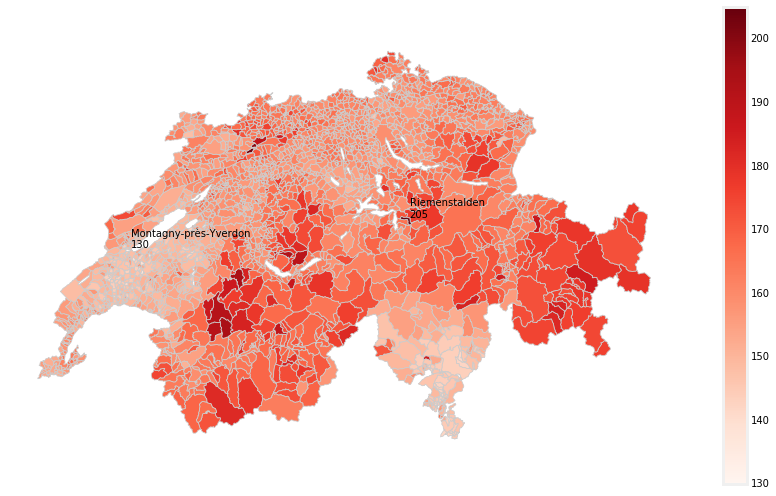

In [30]:
# Generieren einer Gemeindekarte. 
gdf = gpd.read_file('../../grundlagendaten/karten/gemeindegrenzen/2018/ggg_2018-LV95/shp/g1g18.shp')
gdf.crs = {'init' :'epsg:2056'}

# Der eigentliche Datensatz wird angefügt.
gdf['GMDNR'] = gdf['GMDNR'].astype('int')
gdf = pd.merge(gdf, df, left_on='GMDNR', right_index=True, how='left')

# Plotten der Karte
fig, ax = plt.subplots(1, figsize=(12, 7))
gdf.plot(column='co2', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')

# Die höchsten und tiefsten Gemeinden werden beschriftet.
gdf_temp = gdf[gdf['co2'] == gdf['co2'].min()].append(gdf[gdf['co2'] == gdf['co2'].max()])
for x, y, label, co2 in zip(gdf_temp['geometry'].centroid.x, gdf_temp['geometry'].centroid.y, gdf_temp['gemeinde'], gdf_temp['co2']):
    t = label + '\n' + str(round(co2))
    ax.annotate(t, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    
# Plotten der Legende.
sm = plt.cm.ScalarMappable(cmap='Reds', 
                           norm=plt.Normalize(vmin=gdf['co2'].min(), vmax=gdf['co2'].max()))
sm._A = []
cbar = fig.colorbar(sm)

# Abspeichern der Karte. 
plt.tight_layout()
plt.savefig('output/co2_karte.svg')

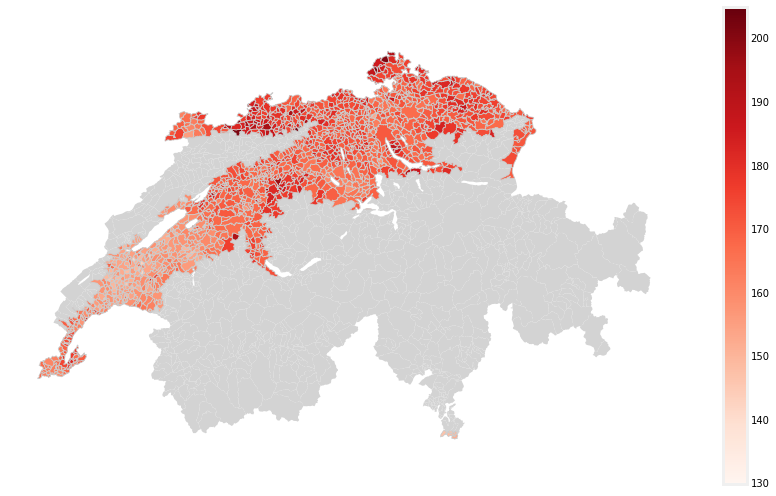

In [31]:
# Die Gebiete mit dem höchsten Ausstoss, die nicht in den Bergen liegen. 
fig, ax = plt.subplots(1, figsize=(12, 7))
gdf.plot(ax=ax, color='lightgrey')
gdf[gdf['berggebiet'] == 'Gemeinde ausseralb der Berggebiete'].sort_values(by='co2', ascending=False).plot(column='co2', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')

# Plotten der Legende.
sm = plt.cm.ScalarMappable(cmap='Reds', 
                           norm=plt.Normalize(vmin=gdf['co2'].min(), vmax=gdf['co2'].max()))
sm._A = []
cbar = fig.colorbar(sm)

# Abspeichern der Karte. 
plt.tight_layout()
plt.savefig('output/co2_karte_flachland.svg')

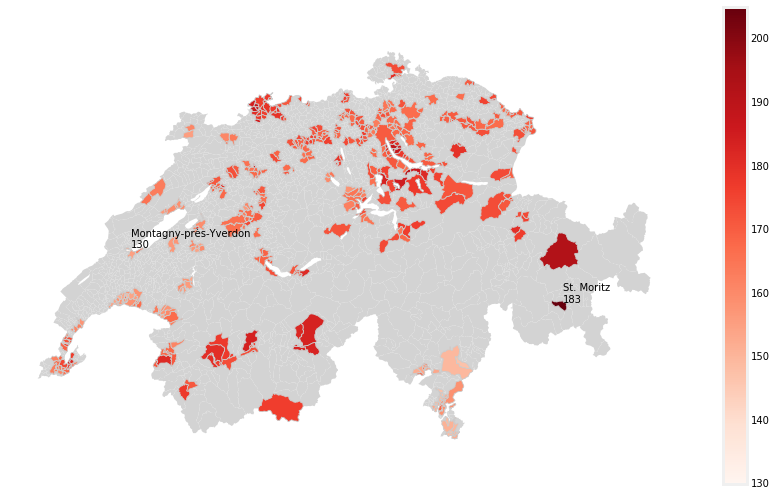

In [32]:
# Die Städte im Vergleich. 
fig, ax = plt.subplots(1, figsize=(12, 7))
gdf.plot(ax=ax, color='lightgrey')
gdf_temp = gdf[gdf['stadt_land'] == 'städtisch']
gdf_temp.sort_values(by='co2', ascending=False).plot(column='co2', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')

# Die höchsten und tiefsten Gemeinden werden beschriftet.
gdf_temp2 = gdf_temp[gdf_temp['co2'] == gdf_temp['co2'].min()].append(gdf_temp[gdf_temp['co2'] == gdf_temp['co2'].max()])
for x, y, label, co2 in zip(gdf_temp2['geometry'].centroid.x, gdf_temp2['geometry'].centroid.y, gdf_temp2['gemeinde'], gdf_temp2['co2']):
    t = label + '\n' + str(round(co2))
    ax.annotate(t, xy=(x, y), xytext=(3, 3), textcoords="offset points")


# Plotten der Legende.
sm = plt.cm.ScalarMappable(cmap='Reds', 
                           norm=plt.Normalize(vmin=gdf['co2'].min(), vmax=gdf['co2'].max()))
sm._A = []
cbar = fig.colorbar(sm)

# Abspeichern der Karte. 
plt.tight_layout()
plt.savefig('output/co2_karte_städte.svg')

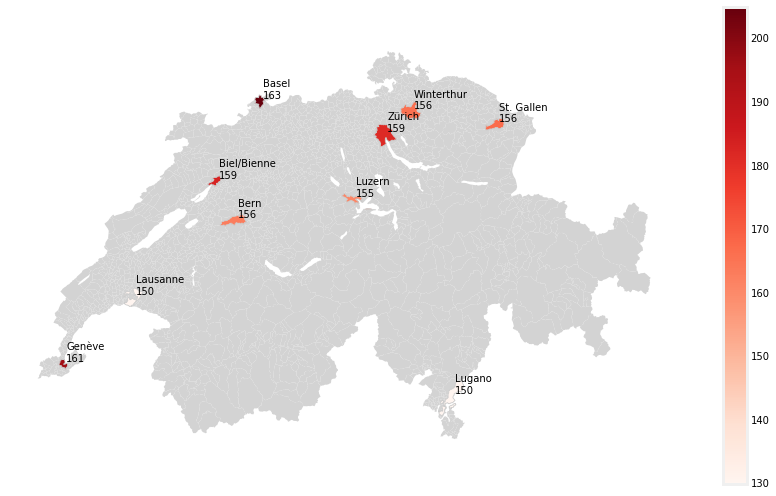

In [33]:
# Die grossen Städte im Vergleich. 
fig, ax = plt.subplots(1, figsize=(12, 7))
gdf.plot(ax=ax, color='lightgrey')
gdf_temp = gdf[(gdf['stadt_land'] == 'städtisch') & (gdf['bev_total'] > 50000)]
gdf_temp.sort_values(by='co2', ascending=False).plot(column='co2', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')

# Die Beschriftungen werden hinzugefügt. 
for x, y, label, co2 in zip(gdf_temp['geometry'].centroid.x, gdf_temp['geometry'].centroid.y, gdf_temp['gemeinde'], gdf_temp['co2']):
    t = label + '\n' + str(round(co2))
    ax.annotate(t, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    
# Plotten der Legende.
sm = plt.cm.ScalarMappable(cmap='Reds', 
                           norm=plt.Normalize(vmin=gdf['co2'].min(), vmax=gdf['co2'].max()))
sm._A = []
cbar = fig.colorbar(sm)

# Abspeichern der Karte. 
plt.tight_layout()
plt.savefig('output/co2_karte_städte.svg')

## Exporte für Interaktiv

In [34]:
# Berggebiete.
df_temp = df[df['berggebiet'] == 'Gemeinde im Berggebiet']
df_temp = df_temp[['gemeinde', 'kanton', 'stadt_land', 'anz_fahrzeuge', 'co2', 'bev_mann', 'bev_frau', 'bev_total']].sort_values(by='co2', ascending=False)
df_temp['gemeinde'] = df_temp['gemeinde'].apply(lambda x: x.split(' (')[0])
df_temp.to_csv('output/1_berggebiete.csv')
print(df_temp.to_csv(index=None))

gemeinde,kanton,stadt_land,anz_fahrzeuge,co2,bev_mann,bev_frau,bev_total
Riemenstalden,SZ,ländlich,39,204.89743589743588,44.0,46.0,90.0
Seehof,BE,ländlich,42,203.28571428571428,31.0,27.0,58.0
Schelten,BE,ländlich,19,199.26315789473685,17.0,19.0,36.0
Lauenen,BE,ländlich,480,194.1520833333333,392.0,433.0,825.0
Oberwil im Simmental,BE,ländlich,455,193.9692307692308,416.0,392.0,808.0
Horrenbach-Buchen,BE,ländlich,88,192.125,128.0,106.0,234.0
Saanen,BE,intermediär,4667,191.25969573601887,3460.0,3357.0,6817.0
Gsteig,BE,ländlich,667,191.00599700149925,494.0,484.0,978.0
Habkern,BE,ländlich,323,189.96284829721358,322.0,317.0,639.0
Ferden,VS,ländlich,129,188.51937984496124,136.0,117.0,253.0
Beinwil,SO,ländlich,186,188.1236559139785,146.0,137.0,283.0
Saxeten,BE,ländlich,59,186.77966101694915,56.0,43.0,99.0
Furna,GR,ländlich,101,186.3861386138614,110.0,111.0,221.0
Rougemont,VD,ländlich,639,186.34898278560246,437.0,445.0,882.0
Boltigen,BE,ländlich,760,185.75789473684208,635.0,627.0,1262.0
S-chanf,G

In [35]:
# Grossstädte mit über 100'000 Einwohner. 
df_temp = df[df['berggebiet'] != 'Gemeinde im Berggebiet']
df_temp = df_temp[df_temp['bev_total'] > 100000]
df_temp['gemeinde'] = df_temp['gemeinde'].apply(lambda x: x.split(' (')[0])
df_temp[['gemeinde', 'kanton', 'anz_fahrzeuge', 'co2', 'bev_mann', 'bev_frau', 'bev_total']].sort_values(by='co2', ascending=False).to_csv('output/2.1_grossstädte.csv')
print(df_temp[['gemeinde', 'kanton', 'anz_fahrzeuge', 'co2']].to_csv(index=None))

gemeinde,kanton,anz_fahrzeuge,co2
Winterthur,ZH,39720,156.0139224572004
Zürich,ZH,117135,158.68919564957568
Bern,BE,47103,155.51325817888457
Basel,BS,50469,162.77352434167508
Lausanne,VD,47229,149.82944800863874
Genève,GE,65388,161.2441236293566



In [36]:
# Alle Städte.
df_temp = df[df['berggebiet'] != 'Gemeinde im Berggebiet']
#df_temp = df_temp[df_temp['bev_total'] <= 100000]
df_temp = df_temp[df_temp['stadt_land'] == 'städtisch']
df_temp['gemeinde'] = df_temp['gemeinde'].apply(lambda x: x.split(' (')[0])
df_temp[['gemeinde', 'kanton', 'anz_fahrzeuge', 'co2', 'bev_mann', 'bev_frau', 'bev_total']].sort_values(by='co2', ascending=False).to_csv('output/2.2_städte.csv')
print(df_temp[['gemeinde', 'kanton', 'anz_fahrzeuge', 'co2']].to_csv(index=None))

gemeinde,kanton,anz_fahrzeuge,co2
Affoltern am Albis,ZH,5612,156.3007840342124
Hedingen,ZH,1722,155.64866434378632
Feuerthalen,ZH,1580,156.07151898734176
Flurlingen,ZH,621,154.80676328502415
Bachenbülach,ZH,2103,155.12030432715167
Bassersdorf,ZH,5626,156.0584784927124
Bülach,ZH,9569,154.41759849514057
Dietlikon,ZH,3986,154.63597591570496
Embrach,ZH,4682,156.1433148227253
Freienstein-Teufen,ZH,1294,155.13369397217932
Höri,ZH,1653,157.4954627949183
Kloten,ZH,9344,156.17701198630138
Opfikon,ZH,8906,156.38771614641814
Rorbas,ZH,1482,155.33805668016194
Wallisellen,ZH,8147,155.3177856879833
Winkel,ZH,2657,159.34776063229202
Niederglatt,ZH,2597,158.68040046207162
Niederhasli,ZH,4785,157.35862068965514
Oberglatt,ZH,3310,160.51027190332326
Regensdorf,ZH,9954,153.14786539427422
Dürnten,ZH,3650,157.22136986301368
Rüti,ZH,5631,156.01012073863637
Wetzikon,ZH,11335,157.09713277459196
Adliswil,ZH,7476,155.70171214553238
Kilchberg,ZH,3889,166.1108254049884
Langnau am Albis,ZH,3400,158.22235294117647
O

In [37]:
# Agglo.
df_temp = df[df['berggebiet'] != 'Gemeinde im Berggebiet']
df_temp = df_temp[df_temp['stadt_land'] == 'intermediär']
df_temp['gemeinde'] = df_temp['gemeinde'].apply(lambda x: x.split(' (')[0])
df_temp[['gemeinde', 'kanton', 'anz_fahrzeuge', 'co2', 'bev_mann', 'bev_frau', 'bev_total']].sort_values(by='co2', ascending=False).to_csv('output/2.3_intermediär.csv')
print(df_temp[['gemeinde', 'kanton', 'anz_fahrzeuge', 'co2']].sort_values(by='co2', ascending=False).to_csv(index=None))

gemeinde,kanton,anz_fahrzeuge,co2
Dittingen,BL,398,174.39949748743717
Brislach,BL,937,173.32337246531483
Hellikon,AG,480,171.68125
Oberdorf,BL,1198,170.75041736227044
Grellingen,BL,932,170.60729613733906
Niederdorf,BL,1035,169.72946859903382
Wahlen,BL,786,169.21882951653944
Schleitheim,SH,901,169.10876803551608
Zwingen,BL,1429,169.03289013296012
Berg am Irchel,ZH,344,168.86627906976744
Biel-Benken,BL,1951,168.84264479753972
Nunningen,SO,1127,168.58473824312333
Fisibach,AG,266,168.49248120300751
Hofstetten-Flüh,SO,1736,168.3375576036866
Laufen,BL,2633,168.1986327383213
Uitikon,ZH,2278,167.99253731343285
Ettingen,BL,2537,167.9329917225069
Röschenz,BL,1027,167.9006815968841
Oberwil-Lieli,AG,1354,166.89586410635155
Duggingen,BL,802,166.5985037406484
Hölstein,BL,1398,166.24177396280402
Zullwil,SO,348,166.20402298850576
Deisswil bei Münchenbuchsee,BE,73,166.1369863013699
Bättwil,SO,644,165.89440993788818
Gottlieben,TG,163,165.840490797546
Hagneck,BE,263,165.48669201520912
Walterswil,SO,439,1

In [38]:
# Ländliche Gebiete.
df_temp = df[df['berggebiet'] != 'Gemeinde im Berggebiet']
df_temp = df_temp[df_temp['stadt_land'] == 'ländlich']
df_temp['gemeinde'] = df_temp['gemeinde'].apply(lambda x: x.split(' (')[0])
df_temp[['gemeinde', 'kanton', 'anz_fahrzeuge', 'co2', 'bev_mann', 'bev_frau', 'bev_total']].sort_values(by='co2', ascending=False).to_csv('output/2.4_land.csv')
print(df_temp[['gemeinde', 'kanton', 'anz_fahrzeuge', 'co2']].sort_values(by='co2', ascending=False).to_csv(index=None))

gemeinde,kanton,anz_fahrzeuge,co2
Kilchberg,BL,86,182.8604651162791
Häfelfingen,BL,168,181.2142857142857
Liesberg,BL,653,180.46094946401226
Beggingen,SH,280,180.125
Burg im Leimental,BL,171,180.11111111111111
Oberhallau,SH,237,180.05907172995782
Greng,FR,117,178.7264957264957
Rumendingen,BE,53,177.49056603773587
Schönenbuch,BL,835,177.30898203592815
Ochlenberg,BE,162,177.01851851851848
Seewen,SO,676,175.6568047337278
Anwil,BL,305,175.19672131147541
Wintersingen,BL,404,175.0
Hermrigen,BE,208,174.4326923076923
Oberbalm,BE,447,174.25279642058166
Nenzlingen,BL,273,174.16483516483515
Bargen,SH,205,173.70243902439026
Häutligen,BE,172,173.69186046511632
Roggenburg,BL,165,172.5878787878788
Reisiswil,BE,122,172.155737704918
Ederswiler,JU,70,172.0857142857143
Bretzwil,BL,424,171.74528301886792
Gächlingen,SH,479,171.544885177453
Hallau,SH,1203,171.09642560266002
Raperswilen,TG,291,170.52577319587633
Oeschenbach,BE,170,170.3470588235294
Reigoldswil,BL,783,170.22605363984675
Mammern,TG,317,170.1829

In [39]:
# Alle städtischen Gebiete inklusive Grossstädte.
df_temp = df[df['stadt_land'] == 'städtisch']
df_temp[['gemeinde', 'kanton', 'anz_fahrzeuge', 'co2']].sort_values(by='co2', ascending=False).to_csv('output/4_alle_städtischen_gebiete.csv')
print(df_temp[['gemeinde', 'kanton', 'anz_fahrzeuge', 'co2']].sort_values(by='co2', ascending=False).to_csv(index=None))

gemeinde,kanton,anz_fahrzeuge,co2
St. Moritz,GR,3414,183.04950205038082
Davos,GR,5328,174.05611861861863
Wollerau,SZ,4393,173.15866150694288
Binningen,BL,6400,171.5409375
Küsnacht (ZH),ZH,6284,171.41152132399745
Oberwil (BL),BL,5251,170.78823081317844
Bottmingen,BL,3076,170.70221066319897
Erlenbach (ZH),ZH,2692,170.6561455625696
Cologny,GE,3061,170.49166938908854
Herrliberg,ZH,3270,170.26452599388378
Freienbach,SZ,10159,169.90284476818584
Lalden,VS,346,169.29190751445088
Augst,BL,624,169.09615384615384
Oberägeri,ZG,3443,169.0255591054313
Pfeffingen,BL,1370,168.63795620437955
Allschwil,BL,8694,168.35035656774787
Feldbrunnen-St. Niklaus,SO,676,168.13461538461542
Crans-Montana,VS,3405,167.9459618208517
Naters,VS,4667,167.78208699378615
Zug,ZG,15293,167.68671941411102
Brig-Glis,VS,6306,167.62194735172852
Visp,VS,4214,167.593735168486
Zollikon,ZH,5617,166.91223072814668
Baltschieder,VS,681,166.90748898678413
Altendorf,SZ,4382,166.61729803742585
Bönigen,BE,1140,166.36315789473684
Vandoeuvres

In [40]:
# Alle städtischen Gebiete inklusive Grossstädte (exklusiv Bergstädte).
df_temp = df[df['stadt_land'] == 'städtisch']
df_temp = df_temp[df_temp['berggebiet'] != 'Gemeinde im Berggebiet']
df_temp['gemeinde'] = df_temp['gemeinde'].apply(lambda x: x.split(' (')[0])
df_temp[['gemeinde', 'kanton', 'anz_fahrzeuge', 'co2']].sort_values(by='co2', ascending=False).to_csv('output/4_alle_städtischen_ohne_berggebiete.csv')
print(df_temp[['gemeinde', 'kanton', 'anz_fahrzeuge', 'co2']].sort_values(by='co2', ascending=False).to_csv(index=None))

gemeinde,kanton,anz_fahrzeuge,co2
Wollerau,SZ,4393,173.15866150694288
Binningen,BL,6400,171.5409375
Küsnacht,ZH,6284,171.41152132399745
Oberwil,BL,5251,170.78823081317844
Bottmingen,BL,3076,170.70221066319897
Erlenbach,ZH,2692,170.6561455625696
Cologny,GE,3061,170.49166938908854
Herrliberg,ZH,3270,170.26452599388378
Freienbach,SZ,10159,169.90284476818584
Augst,BL,624,169.09615384615384
Pfeffingen,BL,1370,168.63795620437955
Allschwil,BL,8694,168.35035656774787
Feldbrunnen-St. Niklaus,SO,676,168.13461538461542
Zollikon,ZH,5617,166.91223072814668
Vandoeuvres,GE,1384,166.3041907514451
Birsfelden,BL,3910,166.13350383631715
Kilchberg,ZH,3889,166.1108254049884
Salmsach,TG,775,165.8774193548387
Zumikon,ZH,2571,165.79774406845584
Rüschlikon,ZH,2768,165.6940028901734
Therwil,BL,4587,165.60475256158708
Füllinsdorf,BL,2480,165.3229838709677
Neuhausen am Rheinfall,SH,4612,165.04640069384212
Schwadernau,BE,396,164.81565656565655
Liestal,BL,6941,164.73173894251548
Münchenstein,BL,5444,164.72060984570

In [41]:
df_temp = df_temp[df_temp['berggebiet'] != 'Gemeinde im Berggebiet']
df_temp['gemeinde'] = df_temp['gemeinde'].apply(lambda x: x.split(' (')[0])
print(df_temp[['gemeinde', 'kanton', 'stadt_land', 'anz_fahrzeuge', 'co2']].to_csv(index=False))

gemeinde,kanton,stadt_land,anz_fahrzeuge,co2
Affoltern am Albis,ZH,städtisch,5612,156.3007840342124
Hedingen,ZH,städtisch,1722,155.64866434378632
Feuerthalen,ZH,städtisch,1580,156.07151898734176
Flurlingen,ZH,städtisch,621,154.80676328502415
Bachenbülach,ZH,städtisch,2103,155.12030432715167
Bassersdorf,ZH,städtisch,5626,156.0584784927124
Bülach,ZH,städtisch,9569,154.41759849514057
Dietlikon,ZH,städtisch,3986,154.63597591570496
Embrach,ZH,städtisch,4682,156.1433148227253
Freienstein-Teufen,ZH,städtisch,1294,155.13369397217932
Höri,ZH,städtisch,1653,157.4954627949183
Kloten,ZH,städtisch,9344,156.17701198630138
Opfikon,ZH,städtisch,8906,156.38771614641814
Rorbas,ZH,städtisch,1482,155.33805668016194
Wallisellen,ZH,städtisch,8147,155.3177856879833
Winkel,ZH,städtisch,2657,159.34776063229202
Niederglatt,ZH,städtisch,2597,158.68040046207162
Niederhasli,ZH,städtisch,4785,157.35862068965514
Oberglatt,ZH,städtisch,3310,160.51027190332326
Regensdorf,ZH,städtisch,9954,153.14786539427422
Dürnten,ZH